In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from datetime import datetime
import calendar
from math import sin, cos, sqrt, atan2, radians
from folium import FeatureGroup, LayerControl, Map, Marker
from folium.plugins import HeatMap
import matplotlib.dates as mdates
import matplotlib as mpl
from datetime import timedelta
import datetime as dt
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')
import folium
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import pickle

### import 관련 노트
+ import warnings /// warnings.filterwarnings('ignore') 두 문장 사이에 import 된 건에 대해서만 warning이 숨겨지는 건지

+ folium = 지도 라이브러리 / 설치 진행 pip install folium

+ from sklearn.preprocessing import Imputer 하기 오류 발생 --> from sklearn.impute import SimpleImputer
     - ImportError: cannot import name 'Imputer' from 'sklearn.preprocessing' (C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\__init__.py)
     - Imputer 3 버전 전에 사용되지 않음 / 0.22에서 제거
     - SimpleImputer 용도: 간단하게 결측치 대체 (총 6개 파라미터 제공, 모두 파라미터 기본값 존재)
     - [SimpleImputer 관련 참고](https://jerry-style.tistory.com/m/62).

In [3]:
train = pd.read_csv('C:/Python/00 Study/003_New York City Taxi Trip Duration_EDA + Baseline Model(0.40 RMSE)/train.csv')
test = pd.read_csv('C:/Python/00 Study/003_New York City Taxi Trip Duration_EDA + Baseline Model(0.40 RMSE)/test.csv')
test.shape
# 행/열 수 반환

(625134, 9)

### Convert to appropriate datatype

In [4]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'], format = '%Y-%m-%d %H:%M:%S')
train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'], format = '%Y-%m-%d %H:%M:%S')
train.head()
# 승차_날짜시간과 하차_날짜시간 datetime 형식으로 변환

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


### Are there any missing values in the data?

In [5]:
train[pd.isnull(train)].sum()
# 결측값은 없음
# id, store_and_fwd_flag의 dtype 원본 노트와 상이 (원본 노트 = float64)
# 해당 2개 열은 문자 혹은 정수 타입이기 때문인 것으로 보임

id                    0  
vendor_id             0.0
passenger_count       0.0
pickup_longitude      0.0
pickup_latitude       0.0
dropoff_longitude     0.0
dropoff_latitude      0.0
store_and_fwd_flag    0  
trip_duration         0.0
dtype: object

In [6]:
train['id']

0          id2875421
1          id2377394
2          id3858529
3          id3504673
4          id2181028
             ...    
1458639    id2376096
1458640    id1049543
1458641    id2304944
1458642    id2714485
1458643    id1209952
Name: id, Length: 1458644, dtype: object

In [7]:
train['store_and_fwd_flag']

0          N
1          N
2          N
3          N
4          N
          ..
1458639    N
1458640    N
1458641    N
1458642    N
1458643    N
Name: store_and_fwd_flag, Length: 1458644, dtype: object

### What is the time period of the dataset?

In [8]:
print('Min pickup time:', min (train['pickup_datetime']))
print('Max pickup time:', max (train['pickup_datetime']))
# min/max 사용 - 승차 시간의 범위 확인

Min pickup time: 2016-01-01 00:00:17
Max pickup time: 2016-06-30 23:59:39


+ the data has 6 months of taxi trip data, from Jan to Jun 2016 - 2016년 1월~6월, 6개월 간의 택시 승차시간 데이터 확인

### Create new day, month, hour info from pickup time

In [9]:
train['pickup_date'] = train['pickup_datetime'].dt.date
train['pickup_day'] = train['pickup_datetime'].apply(lambda x: x.day)
train['pickup_hour'] = train['pickup_datetime'].apply(lambda x: x.hour)
train['pickup_day_of_week'] = train['pickup_datetime'].apply(lambda x: calendar.day_name[x.weekday()])
train['dropoff_date'] = train['dropoff_datetime'].dt.date
train['dropoff_day'] = train['dropoff_datetime'].apply(lambda x: x.day)
train['dropoff_hour'] = train['dropoff_datetime'].apply(lambda x: x.hour)
train['dropoff_day_of_week'] = train['dropoff_datetime'].apply(lambda x: calendar.day_name[x.weekday()])

# 승하차 날짜시간 정보 단위별로 나누어 새로운 열 생성
# dt.date - 년월일 추출
# apply(lambda 입력값: 결과값) - 요일, 시간, 추출
    # 특정 열에 함수 적용 원할 시, def 함수이름(변수): return 을 대신해서 사용 가능 (단순한 사칙연산, 간단한 문자열 추출에 용이)
# 년월일 제외하고는 dt 아닌 apply(lambda) 적용한 이유?

### Round lat lng to 3 decimal places

In [10]:
train['pickup_latitude_round3'] = train['pickup_latitude'].apply(lambda x: round(x, 3))
train['pickup_longitude_round3'] = train['pickup_longitude'].apply(lambda x: round(x, 3))
train['dropoff_latitude_round3'] = train['dropoff_latitude'].apply(lambda x: round(x, 3))
train['dropoff_longitude_round3'] = train['dropoff_longitude'].apply(lambda x: round(x, 3))

train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,17,Monday,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,0,Sunday,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,11,Tuesday,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,19,Wednesday,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,13,Saturday,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973


### Based on latitude and longitude get the distance of the trip in km
+ This uses Haversine Distance

In [11]:
def calculateDistance(row):
    R = 6373.0 # approximate radius of earth in km
    pickup_lat = radians(row['pickup_latitude'])
    pickup_lon = radians(row['pickup_longitude'])
    dropoff_lat = radians(row['dropoff_latitude'])
    dropoff_lon = radians(row['dropoff_longitude'])
    dlon = dropoff_lon - pickup_lon
    dlat = dropoff_lat - pickup_lat
    
    a = sin(dlat / 2)**2 + cos(pickup_lat) * cos(dropoff_lat) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    
    return distance

In [12]:
train['trip_distance'] = train.apply(lambda row: calculateDistance(row), axis = 1)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,Monday,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965,1.498991
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,Sunday,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999,1.806074
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,Tuesday,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005,6.387103
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,Wednesday,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012,1.485965
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,Saturday,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973,1.188962


In [13]:
train['trip_duration_in_hour'] = train['trip_duration'].apply(lambda x: x / 3600)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance,trip_duration_in_hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965,1.498991,0.126389
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999,1.806074,0.184167
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005,6.387103,0.590000
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012,1.485965,0.119167
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973,1.188962,0.120833


### Exploratory analysis

Text(0.5, 0, 'Trip Duration (in hour)')

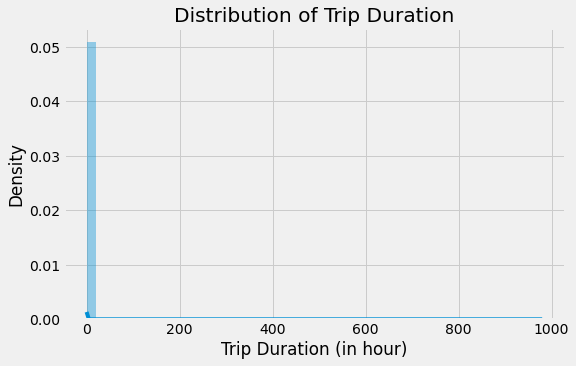

In [14]:
plt.figure(figsize = (8, 5))
sns.distplot(train['trip_duration_in_hour']).set_title("Distribution of Trip Duration")
plt.xlabel("Trip Duration (in hour)")

In [15]:
# there are trip duration greater than 24 hours. We will have to investigate this?

In [16]:
# 24시간 이상인 이동시간 관련 탐색 필요
outlier_trip_duration = train.loc[train['trip_duration_in_hour'] > 24]
outlier_trip_duration

# loc = location 사용, 24시간 이상인 이동시간을 outlier로 정의

# outliers - 4개 기록에서 매우 긴 이동시간 + 짧은 이동 거리 확인
# 특정 위치에서 운행이 시작/종료되었는지 확인 필요
# 왜곡된 이동시간을 log로 변환 하여 확인 필요
# test data에도 포함되어 있을 가능성이 있기 떄문에, outliers 삭제하지 않고 진행

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance,trip_duration_in_hour
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.789650,40.643559,-73.956810,40.773087,N,...,2016-01-27,27,11,Wednesday,40.644,-73.790,40.773,-73.957,20.154989,538.815556
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.921677,40.735252,-73.984749,40.759979,N,...,2016-03-08,8,15,Tuesday,40.735,-73.922,40.760,-73.985,5.984365,569.327222
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.983788,40.742325,-73.985489,40.727676,N,...,2016-01-31,31,1,Sunday,40.742,-73.984,40.728,-73.985,1.635641,618.781111
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.783905,40.648632,-73.978271,40.750202,N,...,2016-03-25,25,18,Friday,40.649,-73.784,40.750,-73.978,19.906909,979.522778


Text(0.5, 1.0, 'Distribution of Trip Duration (sec) in Log Scale')

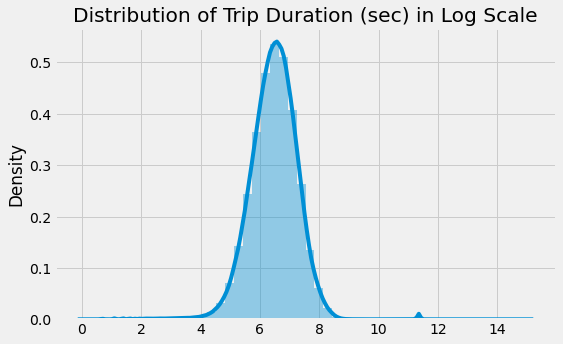

In [17]:
plt.figure(figsize = (8, 5))
sns.distplot(np.log(train['trip_duration'].values)).set_title("distribution of Trip Duration")
plt.title("Distribution of Trip Duration (sec) in Log Scale")

# log 변환에서 정규 분포 확인
# 대부분의 이동시간은 54초 (exp(4)) ~ 2980초 (exp(8)) 범위로, 1시간 이내
# 1분 미만의 이동시간인 데이터도 확인 필요
# 뉴욕 내에서만 운행된 택시임에도 100시간이 넘는 레코드 확인 필요

### Heatmap of common location from where pickup and dropoff occurs

In [18]:
pickup = train.groupby(['pickup_latitude_round3', 'pickup_longitude_round3'])['id'].count().reset_index().rename(columns = {'id': 'Num_Trips'})

# pickup에 승차 위/경도 별 groupby 리스팅, count() 진행하여 Num_Trips 열에 숫자 추가

In [19]:
pickup

,pickup_latitude_round3,pickup_longitude_round3,Num_Trips
0,34.360,-65.848,1
1,34.712,-75.354,1
2,35.082,-71.800,1
3,35.310,-72.074,1
4,36.029,-77.441,1
...,...,...,...
13019,43.140,-72.591,1
13020,43.487,-74.195,1
13021,43.912,-71.882,1
13022,44.372,-66.972,1


In [20]:
pickup_map = folium.Map(location = [40.730610, -73.935242], zoom_start = 10,)

# print(pickup.shape)
### for each pickup point add a circlemarkder

'''
for index, row in pickup.iterrows():
    count = 0
    folium.CircleMarker([row['pickup_latitude_round3'], row['pickup_longitude_round3']],
                         
                         radius = 3,
                         
                         fill_color = '#3db7e4',
                         fill_opacity = 0.1
                         ).add_to(pickup_map)
    count += count
'''

pickup.Num_Trips = np.array(pickup.Num_Trips.values).astype('float64')

hm_wide = HeatMap( list(zip(pickup.pickup_latitude_round3.values, pickup.pickup_longitude_round3.values, pickup.Num_Trips.values)), min_opacity = 0.95, radius = 5, blur = 10, max_zoom = 1)
pickup_map.add_child(hm_wide)

pickup_map

# 에러발생 - TypeError: Object of type int64 is not JSON serializable
# Num_Trips 값을 정수 > 실수로 변환하여 이후 식 적용
# min_opacity 조정 0.2 > 0.95

(-74.03, -73.75)

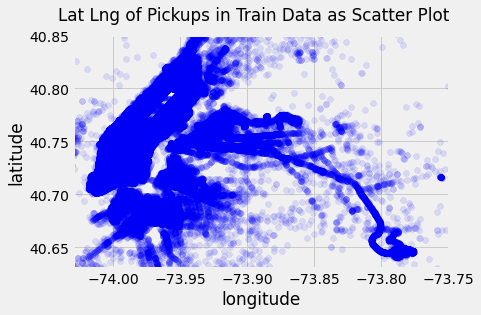

In [21]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols = 1, sharex = True, sharey = True)
    # sharex/sharey: 모든 서브플롯이 같은 x/y축 눈금을 사용하도록 -- x/ylim 조정하여 모든 서브플롯에 조정
ax.scatter(train['pickup_longitude'], train['pickup_latitude'], color = 'blue', label = 'train', alpha = 0.1)

fig.suptitle('Lat Lng of Pickups in Train Data as Scatter Plot')

ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)

In [22]:
# This graph clearly shows heavy density of pickups near JFK
# JFK 공항 근처 높은 승차 밀도

In [23]:
drop = train.groupby(['dropoff_latitude_round3', 'dropoff_longitude_round3'])['id'].count().reset_index().rename(columns = {'id': 'Num_Trips'})

In [24]:
drop

,dropoff_latitude_round3,dropoff_longitude_round3,Num_Trips
0,32.181,-73.835,1
1,34.360,-65.848,1
2,35.174,-72.022,1
3,36.029,-77.441,1
4,36.119,-68.778,1
...,...,...,...
31444,43.148,-69.048,1
31445,43.487,-74.195,1
31446,43.674,-79.554,1
31447,43.912,-71.882,1


In [25]:
drop_map = folium.Map(location = [40.730610, -73.935242], zoom_start = 10,)
# print(pickup.shape)
### For each pickup point add a circlemarker

'''
for index, row in drop.iterrows():
    folium.CircleMarker([row['dropoff_latitude_round3'], row ['dropoff_longitude_round3']],
                        radius = 3,
                        color = '#00800',
                        fill_opacity = 0.9
                        ).add_to(drop_map)
    count = count + 1
'''

drop.Num_Trips = np.array(drop.Num_Trips.values).astype('float64')

hm_wide = HeatMap( list(zip(drop.dropoff_latitude_round3.values, drop.dropoff_longitude_round3.values, drop.Num_Trips.values)),
                 min_opacity = 0.95,
                 radius = 5, blur = 15,
                 max_zoom = 1
                 )
drop_map.add_child(hm_wide)

drop_map

# min_opacity 조정 0.2 > 0.95

In [26]:
# Dropoff Heatmap is similar to pickup
# 승-하차 히트맵 유사

### Heatmap of trip duration, when pickup originates from a point

In [27]:
pickup = train.groupby(['pickup_latitude_round3', 'pickup_longitude_round3'])['trip_duration'].mean().reset_index().rename(columns = {'trip_duration': 'Avg_Trip_duration'})

In [28]:
pickup

,pickup_latitude_round3,pickup_longitude_round3,Avg_Trip_duration
0,34.360,-65.848,961.0
1,34.712,-75.354,875.0
2,35.082,-71.800,611.0
3,35.310,-72.074,317.0
4,36.029,-77.441,782.0
...,...,...,...
13019,43.140,-72.591,799.0
13020,43.487,-74.195,674.0
13021,43.912,-71.882,632.0
13022,44.372,-66.972,1131.0


In [29]:
pickup_map = folium.Map(location = [40.730610, -73.935242], zoom_start = 10,)

hm_wide = HeatMap( list(zip(pickup.pickup_latitude_round3.values, pickup.pickup_longitude_round3.values, pickup.Avg_Trip_duration.values)),
                 min_opacity = 0.95,
                 radius = 7, blur = 15,
                 max_zoom = 1
                 )
pickup_map.add_child(hm_wide)
pickup_map

# min_opacity 조정 0.2 > 0.95

In [30]:
# The average trip duration, when trip originates from JFK is higher. If we zoom in, we can see that after the Manhattan, the pickups from JFK tend to have higher trip duration.
# JFK에서 승차한 경우, 평균 이동시간이 높음

### Which hours are pickup and dropoff higher?

Text(0.5, 1.0, 'Pickup Hours Distribution')

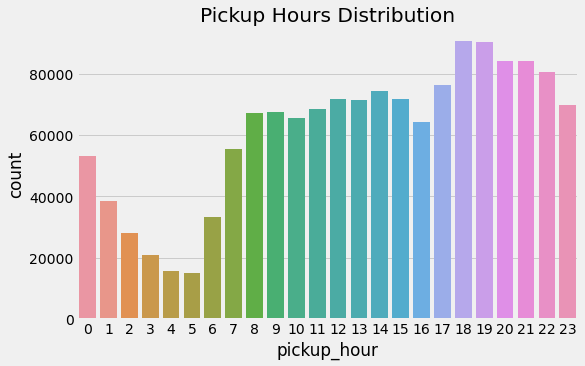

In [31]:
plt.figure(figsize = (8, 5))
sns.countplot(x = train['pickup_hour']).set_title('Pickup Hours Distribution')

In [32]:
# 이른 아침에 승차수가 훨씬 적음
# 오후 6-8시 사이 가장 높은 승차수

Text(0.5, 1.0, 'Dropoff Hours Distribution')

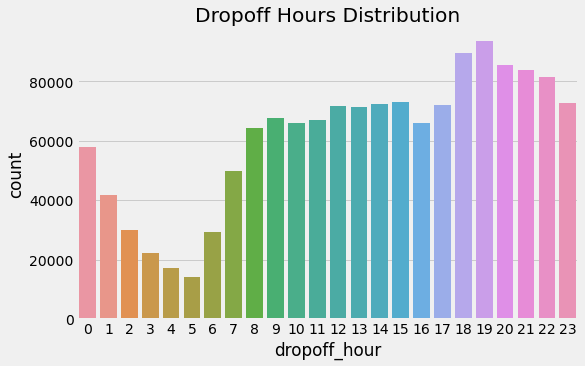

In [33]:
plt.figure(figsize = (8, 5))
sns.countplot(x = train['dropoff_hour']).set_title('Dropoff Hours Distribution')

In [34]:
# 승차-하차 분포 유사

### Pickups over the entire time period

Text(0.5, 1.0, 'Distribution of Pickups over Time')

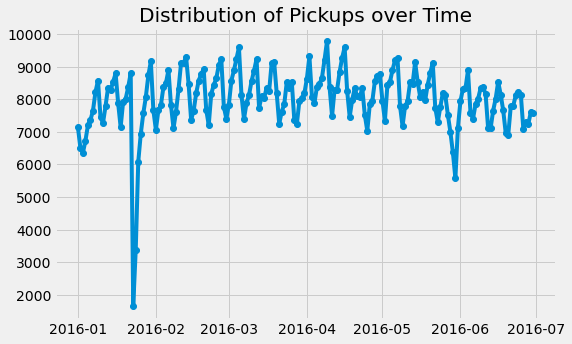

In [35]:
plt.figure(figsize = (8, 5))
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label = 'train')

plt.title('Distribution of Pickups over Time')

In [36]:
# 2016년 1월 승차수 하락 확인

### What is the distribution of Trip distance

Text(0.5, 0, 'Trip Distance (log)')

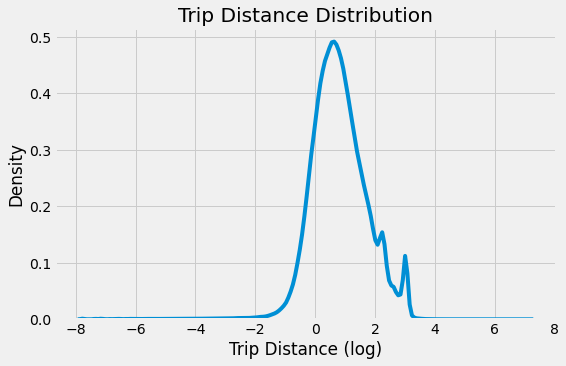

In [37]:
plt.figure(figsize = (8, 5))
sns.kdeplot(np.log(train['trip_distance'].values)).set_title('Trip Distance Distribution')
plt.xlabel('Trip Distance (log)')

### Trip duration vs Trip Distance

Text(0, 0.5, 'Trip Duration (log scale)')

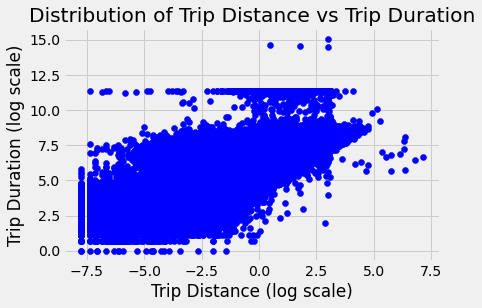

In [38]:
plt.scatter(np.log(train['trip_distance'].values), np.log(train['trip_duration'].values),
            color = 'blue', label = 'train')
plt.title('Distribution of Trip Distance vs Trip Duration')
plt.xlabel('Trip Distance (log scale)')
plt.ylabel('Trip Duration (log scale)')

### Is the trip duration higher at different hours?

TypeError: xlabel() missing 1 required positional argument: 'xlabel'

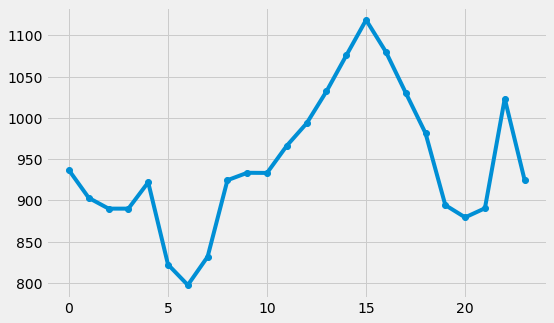

In [39]:
avg_duration_hour = train.groupby(['pickup_hour'])['trip_duration'].mean().reset_index().rename(columns = {'trip_duration' : 'avg_trip_duration'})
plt.figure(figsize = (8, 5))
plt.plot(train.groupby(['pickup_hour'])['trip_duration'].mean(), 'o-')
# x/y축 라벨

In [ ]:
avg_duration_hour

In [ ]:
# 10-15 시간 사이 이동시간 증가 

### Distribution of pickups across Days

<AxesSubplot:xlabel='pickup_day_of_week', ylabel='count'>

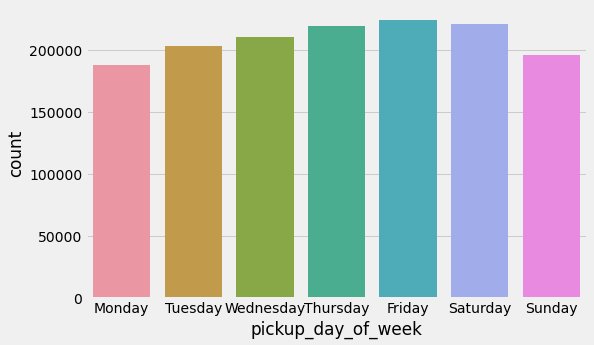

In [40]:
plt.figure(figsize = (8, 5))
sns.countplot(train['pickup_day_of_week'], order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [41]:
# The number of pickups are very low on Monday. From Tuesday to Friday the number of pickups keep increasing
# 월, 화의 승차수는 매우 낮고, 화-금까지는 승차수가 계속적으로 증가

### Avg trip duration over days of week

In [83]:
avg_duration_day = train.groupby(['pickup_day_of_week'])['trip_duration'].mean().reset_index().rename(columns = {'trip_duration' : 'avg_trip_duration'})

KeyError: 'Column not found: trip_duration'

In [43]:
avg_duration_day

,pickup_day_of_week,avg_trip_duration
0,Friday,990.224200
1,Monday,897.947839
2,Saturday,948.051175
3,Sunday,901.639395
4,Thursday,1006.528654
5,Tuesday,983.463124
6,Wednesday,975.450494


Text(0.5, 1.0, 'Avg Trip Duration vs Pickup Days of Week')

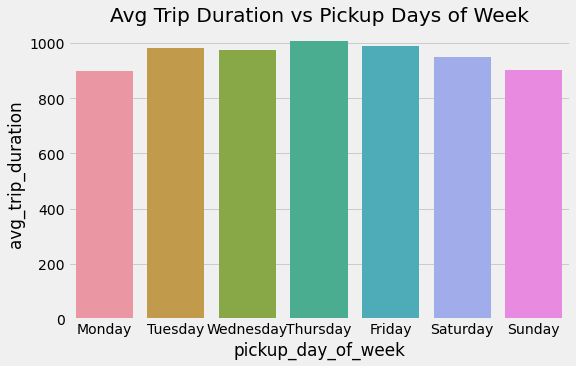

In [44]:
plt.figure(figsize = (8, 5))
sns.barplot(x = 'pickup_day_of_week', y = 'avg_trip_duration', data = avg_duration_day, order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).set_title('Avg Trip Duration vs Pickup Days of Week')

In [ ]:
# 가장 긴 평균 이동 시간은 목요일에 확인됨

### Create a calculated field bearing
+ Bearing으로 이동 방향 확인
+ θ = atan2( sin Δλ ⋅ cos φ2 , cos φ1 ⋅ sin φ2 − sin φ1 ⋅ cos φ2 ⋅ cos Δλ )
+ λ = 경도

In [46]:
def calculateBearing(lat1, lng1, lat2, lng2):
    R = 6371
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [47]:
train['bearing'] = train.apply(lambda row: calculateBearing(row['pickup_latitude_round3'], row['pickup_longitude_round3'], row['dropoff_latitude_round3'], row['dropoff_longitude_round3']), axis = 1)

### Distribution of bearing

<AxesSubplot:xlabel='bearing', ylabel='Density'>

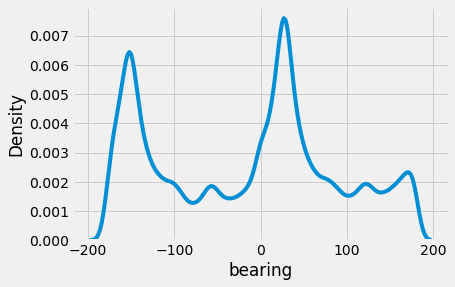

In [48]:
sns.kdeplot(train['bearing'])

### Bearing vs Trip duration

Text(0, 0.5, 'Trip Duration (log scale)')

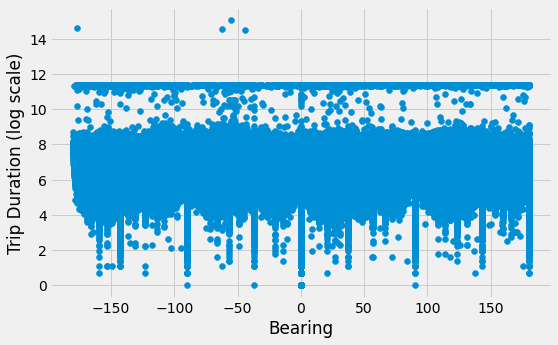

In [49]:
plt.figure(figsize = (8, 5))
plt.scatter(train['bearing'].values, y = np.log(train['trip_duration'].values))
plt.xlabel('Bearing')
plt.ylabel('Trip Duration (log scale)')

In [50]:
# The outliers in trip duration are all around bearing -50 degrees
# 이동시간에서 확인되는 이상치는 모두 -50도 bearing에서 확인됨

### Distribution of store and FWD flag

In [51]:
# store_and_fwd_flag — This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server — Y=store and forward; N=not a store and forward trip.
# 해당 항목은 차가 서버 미연결 상태에서 이동 기록이 메모리에 보관되고 난 후 전송된 경우에 Y로 표시, 아닐 경우에 N으로 표시 

In [52]:
train['store_and_fwd_flag'].value_counts()

N    1450599
Y    8045   
Name: store_and_fwd_flag, dtype: int64

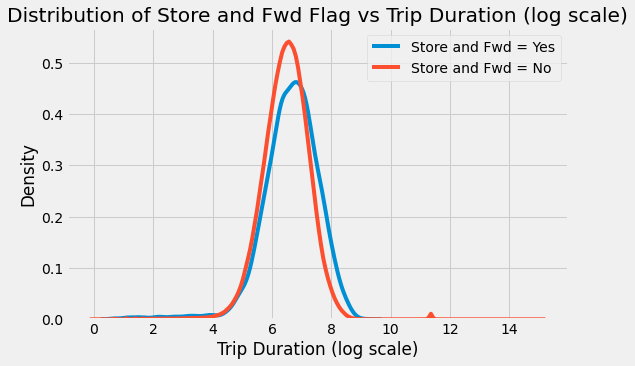

In [53]:
plt.figure(figsize = (8, 5))
sns.kdeplot(np.log(train.loc[train['store_and_fwd_flag'] == 'Y', 'trip_duration'].values), label = 'Store and Fwd = Yes')
sns.kdeplot(np.log(train.loc[train['store_and_fwd_flag'] == 'N', 'trip_duration'].values), label = 'Store and Fwd = No')

plt.title('Distribution of Store and Fwd Flag vs Trip Duration (log scale)')
plt.xlabel('Trip Duration (log scale)')
plt.ylabel('Density')
plt.legend()

### Group location into cluster
+ 이웃(동네) 형성을 위한 과정
+ 특정 동네에서의 승차가 긴 이동시간을 가질 수 있음

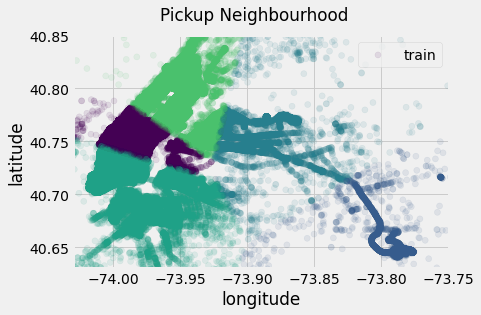

In [54]:
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))
    # numpy vstack 사용, train과 test 데이터의 승하차 위경도의 값을 세로로 결합
    
kmeans = KMeans(n_clusters = 8, random_state = 0).fit(coords)
train.loc[:, 'pickup_neighbourhood'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_neighbourhood'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
    # kmeans = 모델 생성 및 훈련 후 예측
    # k-평균 군집 알고리즘 사용; k개의 중심점 기준으로 군집 형성
    # n_clusters = (k-means의 k 의미) 군집형성(중심점) 개수
    # random_state = 인자
    # fit(군집화하려는데이터)
    
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols = 1, sharex = True, sharey = True)
ax.scatter(train['pickup_longitude'], train['pickup_latitude'], c = train['pickup_neighbourhood'], label = 'train', alpha = 0.1)

fig.suptitle('Pickup Neighbourhood')

ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.legend()

### Number of pickups in each neighbourhood

Text(0.5, 1.0, 'Distribution of Number of Pickups across Neighbourhoods')

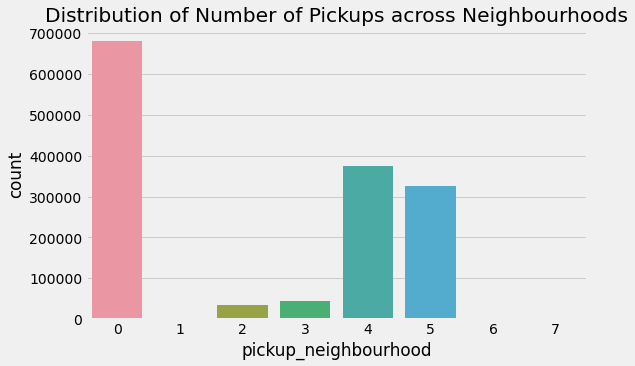

In [55]:
plt.figure(figsize = (8, 5))
sns.countplot(train['pickup_neighbourhood']).set_title('Distribution of Number of Pickups across Neighbourhoods')

Text(0.5, 1.0, 'Avg Trip Duration vs Neighbourhood')

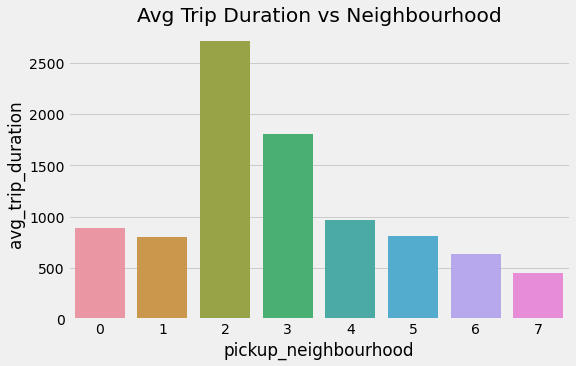

In [56]:
avg_duration_neighbourhood = train.groupby(['pickup_neighbourhood'])['trip_duration'].mean().reset_index().rename(columns = {'trip_duration' : 'avg_trip_duration'})
plt.figure(figsize = (8, 5))
sns.barplot(x = 'pickup_neighbourhood', y = 'avg_trip_duration', data = avg_duration_neighbourhood).set_title('Avg Trip Duration vs Neighbourhood')

In [57]:
# 동네 0에서 대부분의 승차가 이루어지지만, 동네 2가 매우 높은 평균 승차시간을 가짐

### Distribution of average speed

Text(0.5, 1.0, 'Distribution of Average Speed (in kph)')

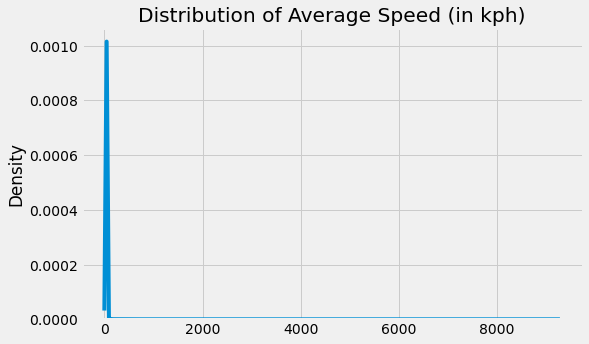

In [58]:
train['avg_speed_kph'] = train['trip_distance'] / train['trip_duration_in_hour']
plt.figure(figsize = (8, 5))
sns.kdeplot(train['avg_speed_kph'].values).set_title('Distribution of Average Speed (in kph)')

In [59]:
print('Average speed is', np.mean(train['avg_speed_kph']), 'kph')

Average speed is 14.427736738458675 kph


### Average speed across days of week  - this is indication of traffic speed

Text(0.5, 1.0, 'Avg Sped (kph) vs Pickup Days of Week')

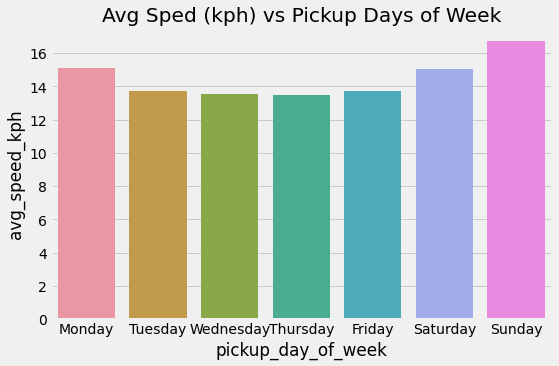

In [60]:
avg_speed_per_day = train.groupby(['pickup_day_of_week'])['avg_speed_kph'].mean().reset_index()
plt.figure(figsize = (8, 5))
sns.barplot(x = 'pickup_day_of_week', y = 'avg_speed_kph', data = avg_speed_per_day, order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).set_title('Avg Sped (kph) vs Pickup Days of Week')

In [61]:
# 일, 월에 평균 속도가 높음

### Feature engineering on Test Data

In [62]:
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'], format = '%Y-%m-%d %H:%M:%S')
#test['dropoff_datetime'] = pd.to_datetime(test['dropoff_datetime'], format = '%Y-%m-%d %H:%M:%S')
test['pickup_date'] = test['pickup_datetime'].dt.date
test['pickup_day'] = test['pickup_datetime'].apply(lambda x: x.day)
test['pickup_hour'] = test['pickup_datetime'].apply(lambda x: x.hour)
test['pickup_day_of_week'] = test['pickup_datetime'].apply(lambda x: calendar.day_name[x.weekday()])
#test['dropoff_date'] = test['dropoff_datetime'].dt.date
#test['dropoff_day'] = test['dropoff_datetime'].apply(lambda x: x.day)
#test['dropoff_hour'] = test['dropoff_datetime'].apply(lambda x: x.hour)
#test['dropoff_day_of_week'] = test['dropoff_datetime'].apply(lambda x: calendar.day_name[x.weekday()])
test['pickup_latitude_round3'] = test['pickup_latitude'].apply(lambda x: round(x, 3))
test['pickup_longitude_round3'] = test['pickup_longitude'].apply(lambda x: round(x, 3))
test['dropoff_latitude_round3'] = test['dropoff_latitude'].apply(lambda x: round(x, 3))
test['dropoff_longitude_round3'] = test['dropoff_longitude'].apply(lambda x: round(x, 3))
test['trip_distance'] = test.apply(lambda row:calculateDistance(row), axis = 1)
#test['trip_duration_in_hour'] = test['trip_duration'].apply(lambda x: x / 3600)
test['bearing'] = test.apply(lambda row: calculateBearing(row['pickup_latitude_round3'], row['pickup_longitude_round3'], row['dropoff_latitude_round3'], row['dropoff_longitude_round3']), axis = 1)
test.loc[:, 'pickup_neighbourhood'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_neighbourhood'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

### Building Models

In [63]:
# Training 데이터 상 'dropoff datetime features' 제외 필요
# 소수점 3자리로 반올림한 위/경도만 유지 예정

In [64]:
drop_cols = ['avg_speed_kph', 'trip_duration_in_hour', 'dropoff_date', 'dropoff_day', 'dropoff_hour', 'dropoff_day_of_week', 'dropoff_datetime', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']
training = train.drop(drop_cols, axis = 1)
testing = test.drop(['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'], axis = 1)

In [65]:
# 이동시간 예측 필요; 로그 스케일로 변경하여 예측

In [66]:
training['log_trip_duration'] = training['trip_duration'].apply(lambda x: np.log(x))
training.drop(['trip_duration'], axis = 1, inplace = True)

In [67]:
print('Training Data Shape ', training.shape)
print('Testing Data Shape ', testing.shape)

Training Data Shape  (1458644, 18)
Testing Data Shape  (625134, 17)


In [68]:
def encodeDays(day_of_week):
    day_dict = {'Sunday': 0, 'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6}
    return day_dict[day_of_week]

In [69]:
training['pickup_day_of_week'] = training['pickup_day_of_week'].apply(lambda x: encodeDays(x))
testing['pickup_day_of_week'] = testing['pickup_day_of_week'].apply(lambda x: encodeDays(x))

In [70]:
training.to_csv('input_training.csv', index = False)
testing.to_csv('input_testing.csv', index = False)
del training
del testing
del train
del test

In [71]:
def LabelEncoding(train_df, test_df, max_levels = 2):
    for col in train_df:
        if train_df[col].dtype == 'object':
            if len(list(train_df[col].unique())) <= max_levels:
                le = preprocessing.LabelEncoder()
                le.fit(train_df[col])
                train_df[col] = le.transform(train_df[col])
                test_df[col] = le.transform(test_df[col])
    return [train_df, test_df]

def readInputAndEncode(input_path, train_file, test_file, target_column):
    training = pd.read_csv(input_path + train_file)
    testing = pd.read_csv(input_path + test_file)
    
    training, testing = LabelEncoding (training, testing)
    
    #print('Training Data Shape after Encoding', training.shape)
    #print('Testing Data Shape after Encoding', testing.shape)
    #Check if all train columns are there in test data. If not add the column to test data and replace it with zero
    train_cols = training.columns.tolist()
    test_cols = testing.columns.tolist()
    col_in_train_not_test = set(train_cols)-set(test_cols)
    for col in col_in_train_not_test:
        if col != target_column:
            testing[col] = 0
    col_in_test_not_train = set(test_cols) - set(train_cols)
    for col in col_in_test_not_train:
        training[col] = 0
    print('Training Data Shape after Processing', training.shape)
    print('Testing Data Shape after Processing', testing.shape)
    return [training, testing]

In [72]:
train, test = readInputAndEncode('', 'input_training.csv', 'input_testing.csv', 'log_trip_duration')
train.drop(['pickup_date'], axis = 1, inplace = True)
test.drop(['pickup_date'], axis = 1, inplace = True)
train.drop(['pickup_datetime'], axis = 1, inplace = True)
test.drop(['pickup_datetime'], axis = 1, inplace = True)
test_id = test['id']
train.drop(['id'], axis = 1, inplace = True)
test.drop(['id'], axis = 1, inplace = True)

Training Data Shape after Processing (1458644, 18)
Testing Data Shape after Processing (625134, 17)


In [73]:
def GetFeaturesAndSplit(train, test, target, imputing_strategy = 'median', split = 0.25, imputation = True):
    labels = np.array(train[target])
    training = train.drop(target, axis = 1)
    training = np.array(training)
    testing = np.array(test)
    if imputation == True:
        imputer = Imputer(strategy = imputing_strategy, missing_values = np.nan)
        imputer.fit(training)
        training = imputer.transform(training)
        testing = imputer.transform(testing)
    train_features, validation_features, train_labels, validation_labels = train_test_split(training, labels, test_size = split, random_state = 42)
    return [train_features, validation_features, train_labels, validation_labels, testing]

In [74]:
train_features, validation_features, train_labels, validation_labels, testing = GetFeaturesAndSplit(train, test, 'log_trip_duration', imputation = False)

### Apply Linear Regression

In [75]:
lm = linear_model.LinearRegression()
lm.fit(train_features, train_labels)

LinearRegression()

In [76]:
valid_pred = lm.predict(validation_features)

In [77]:
rmse = mean_squared_error(validation_labels, valid_pred)
print('Root Mean Squared Error for Linear Regression(log scale) ', rmse)

Root Mean Squared Error for Linear Regression(log scale)  0.40311762496881637


In [78]:
test_pred = lm.predict(testing)
submit = pd.DataFrame()
submit['id'] = test_id
submit['trip_duration'] = np.exp(test_pred)
submit.to_csv('submission_linear_regression_baseline.csv', index = False)
del submit

### Apply Random Forest Regressor

In [79]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)

In [80]:
rf.fit(train_features, train_labels)

RandomForestRegressor(random_state=42)

In [81]:
valid_pred_rf = rf.predict(validation_features)
rmse = mean_squared_error(validation_labels, valid_pred_rf)
print('Root Mean Squared Error for Random Forest', rmse)

Root Mean Squared Error for Random Forest 0.1658653809014289


In [82]:
test_pred = rf.predict(testing)
submit = pd.DataFrame()
submit['id'] = test_id
submit['trip_duration'] = np.exp(test_pred)
submit.to_csv('submission_random_forest_baseline.csv', index = False)